In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Load the data
tra = pd.read_csv("optdigits.tra", header=None)  
tes = pd.read_csv("optdigits.tes", header=None)
df = pd.concat([tra, tes], ignore_index=True) 

In [3]:
# Convert dataframe to numpy array
np_array = df.values 
labels = np_array[:,64]
data = np_array[:,:-1]

In [4]:
data.shape  # 5620 instances, 64 features

(5620, 64)

In [5]:
# Standardize the data
data = (data - np.mean(data)) / (np.std(data) + 1e-8)

## Shallow Autoencoder whose encoder and decoder have just one linear layer

In [6]:
class AutoEncoder():
    def __init__(self, input_dim, hidden_dim):
         
        # Initialize parameters
        np.random.seed(2)
        self.W_enc = np.random.rand(hidden_dim, input_dim) * 0.01
        self.b_enc = np.zeros((hidden_dim, 1))
        self.W_dec = np.random.rand(input_dim, hidden_dim) * 0.01  # output dimension is equal to the input dimension
        self.b_dec = np.zeros((input_dim, 1))
              
    def tanh(self, z):
        return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))

    def tanh_derivative(self, z):
        return 1 - np.power(self.tanh(z), 2)
    
    def relu(self, z):
        return np.maximum(0, z)
            
    def relu_derivative(self, z):
        return (z > 1) * 1   # Multiply by 1 to convert binary values from Boolean
    
    def sigmoid(self, z):
        return 1.0 / (1 + np.exp(-z))
    
    def sigmoid_derivative(self, z):
        return self.sigmoid(z) * (1 - self.sigmoid(z))
    
    def encoder(self, X):
        self.z_enc = np.dot(self.W_enc, X) + self.b_enc
        self.a_enc = self.relu(self.z_enc) 
        return self.a_enc
    
    def decoder(self, encoded):
        decoded = np.dot(self.W_dec, encoded) + self.b_dec
        return decoded
    
    def forward(self, X):
        encoded = self.encoder(X)
        self.out = self.decoder(encoded)
        return self.out
    
    def backward(self, X):
        num_inputs = X.shape[1]
        dz_dec = self.out - X
        self.dW_dec = np.dot(dz_dec, self.a_enc.T) / num_inputs
        self.db_dec = np.sum(dz_dec, axis=1, keepdims=True) / num_inputs
    
        dz_enc = np.dot(self.W_dec.T, dz_dec) * self.relu_derivative(self.z_enc)
        self.dW_enc = np.dot(dz_enc, X.T) / num_inputs
        self.db_enc = np.sum(dz_enc, axis=1, keepdims=True) / num_inputs
    
    def step(self, lr):  
        self.W_enc -= lr * self.dW_enc
        self.b_enc -= lr * self.db_enc
        self.W_dec -= lr * self.dW_dec
        self.b_dec -= lr * self.db_dec
    
    def train(self, X, epochs, learning_rate):
        X = X.T
        
        for epoch in range(epochs):
            reconstructed = self.forward(X)
            self.backward(X)            # Calculate gradients
            self.step(learning_rate)    # Update parameters
            loss = 0.5 * np.mean((X - reconstructed) ** 2)  # Calculate the mean squared error
            if epoch % 10 == 0:         # Print the loss at every 10 epoch
                print(f"Epoch {epoch+1}: loss = {loss:.5f}")
    
    def predict(self, X):
        return self.encoder(X)

In [7]:
model = AutoEncoder(data.shape[1], hidden_dim=2)
model.train(data, epochs=100, learning_rate=0.001)

Epoch 1: loss = 0.49998
Epoch 11: loss = 0.49520
Epoch 21: loss = 0.49051
Epoch 31: loss = 0.48591
Epoch 41: loss = 0.48141
Epoch 51: loss = 0.47699
Epoch 61: loss = 0.47266
Epoch 71: loss = 0.46842
Epoch 81: loss = 0.46426
Epoch 91: loss = 0.46018


## The interval of hidden representation values varies depending on the activation function used.

In [8]:
# If ReLU is used, values will be in [0, x]
# If Tanh is used, values will be in [-1, 1]
# If Sigmoid or Softmax is used, values will be in [0, 1]

hidden_representations = model.predict(data.T)  

In [9]:
def plot_latent(hidden, y):
    plt.figure(figsize=(10,6))
    plt.scatter(hidden[0,:], hidden[1,:], c=y, cmap='gist_rainbow_r') 
    plt.xlabel('Hidden 1')
    plt.ylabel('Hidden 2')
    
    plt.colorbar()
    plt.show()

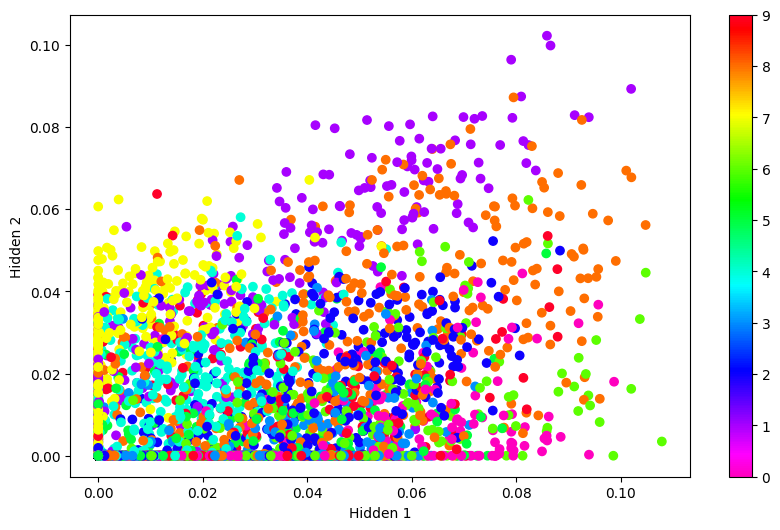

In [10]:
plot_latent(hidden_representations, labels.reshape(-1))